In [ ]:
#

In [25]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from prophet import Prophet
from prophet.diagnostics import cross_validation

# CONSTANT
DATA_PATH = "https://github.com/fakhrirobi/ML_Pacmann_5/blob/main/final/20221120_1110_final_data_2018_2022.xlsx?raw=true"
CITIES = [
    "balikpapan",
    "bandung",
    "batam",
    "jakarta",
    "makassar",
    "medan",
    "palembang",
    "pekanbaru",
    "surabaya",
    "yogyakarta",
]

## Data Loading 

In [67]:
def load_data():
    data = pd.read_excel(DATA_PATH).rename(columns={"Unnamed: 0": "tanggal"})
    data["tanggal"] = pd.to_datetime(data["tanggal"])
    return data

In [68]:
data = load_data()

In [13]:
# extract datetime property : day name , we want to dig in on before and after holiday e.g. sunday saturday
data["day"] = data["tanggal"].dt.day_name()

## Analyzing Missing Values

In [ ]:
parsed_data_log = parsed_data.copy()
parsed_data_log.index = [x for x in range(parsed_data_log.shape[0])]

In [35]:
parsed_data = parsed_data.set_index("tanggal").sort_index()[cities].diff(1)

In [ ]:
fig = make_subplots(rows=10, cols=1)
for idx, city in enumerate(CITIES):

    fig.add_trace(
        go.Scatter(
            y=parsed_data[f"{city}"], x=parsed_data.index, mode="lines", name=f"{city}"
        ),
        row=idx + 1,
        col=1,
    )


fig.update_layout(
    width=1000,
    height=2000,
    margin=dict(l=0, r=0, t=0, b=0),
    paper_bgcolor="#ffffff",
    title="Price Change from Friday to Monday (Skipped Sat and Sun) From Different Cities",
)

In [69]:
def pipe_log_division(data, cities=CITIES):
    """Helper Function to implement log(dayh/day)"""

    for city in cities:
        data[f"{city}_log_ratio"] = np.NaN
        for idx in data.index:
            try:
                data.loc[idx, f"{city}_log_ratio"] = np.log1p(
                    data.at[idx, city] / data.at[idx - 1, city]
                )
            except:
                continue
    return None

In [63]:
parsed_data_log.pipe(pipe_log_division)

In [65]:
parsed_data_log

,tanggal,balikpapan,bandung,batam,jakarta,makassar,medan,palembang,pekanbaru,surabaya,...,balikpapan_log_ratio,bandung_log_ratio,batam_log_ratio,jakarta_log_ratio,makassar_log_ratio,medan_log_ratio,palembang_log_ratio,pekanbaru_log_ratio,surabaya_log_ratio,yogyakarta_log_ratio
0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-05,68300.0,48200.0,63650.0,61350.0,26550.0,50000.0,58500.0,70950.0,54700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-08,68300.0,48200.0,63650.0,61350.0,26550.0,50000.0,58500.0,70950.0,54700.0,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,2018-01-12,72300.0,46300.0,64250.0,66100.0,28000.0,52100.0,58500.0,72550.0,64900.0,...,0.722009,0.673241,0.697849,0.731129,0.720088,0.713930,0.693147,0.704360,0.782289,0.693147
4,2018-01-15,72300.0,46300.0,64250.0,66100.0,28000.0,52100.0,58500.0,72550.0,64900.0,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2022-11-04,130200.0,86950.0,87200.0,98100.0,50050.0,44750.0,86450.0,84350.0,82350.0,...,0.693147,0.693147,0.647223,0.594850,0.690659,0.693147,0.693147,0.693147,0.693147,0.696305
506,2022-11-07,130200.0,86950.0,87200.0,98100.0,50050.0,44750.0,86450.0,84350.0,82350.0,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
507,2022-11-11,130200.0,82450.0,83500.0,99350.0,48550.0,40750.0,89500.0,74600.0,82350.0,...,0.693147,0.666930,0.671703,0.699498,0.678049,0.647425,0.710634,0.633615,0.693147,0.725004
508,2022-11-14,130200.0,82450.0,83500.0,99350.0,48550.0,40750.0,89500.0,74600.0,82350.0,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147


In [ ]:
# plot the log (H/H-1)
log_ratio_df = parsed_data

In [ ]:
data = pd.read_excel(DATA_PATH, converters={"tanggal": np.datetime64})

In [ ]:
data = data.replace("-", np.NaN)

In [ ]:
# there are lots of missing values, those were resulted from holiday calendar such as sunday,saturday,idul fitri , etc, assumed data is the same like previous date
# the missing values imputation in this part will use pandas.backfill and pandas.ffill()
data.isnull().sum()

tanggal         0
medan         353
pekanbaru     356
batam         358
palembang     356
bandung       359
jakarta       359
yogyakarta    359
surabaya      358
balikpapan    348
makassar      359
dtype: int64

In [ ]:
# imputation
city_columns = [x for x in data.columns if x != "tanggal"]
data[city_columns] = data[city_columns].fillna(method="ffill")
data[city_columns] = data[city_columns].fillna(method="bfill")

In [ ]:
data[city_columns] = data[city_columns].astype("float")

In [ ]:
data.dtypes

tanggal       datetime64[ns]
medan                 object
pekanbaru             object
batam                 object
palembang             object
bandung               object
jakarta               object
yogyakarta            object
surabaya              object
balikpapan           float64
makassar              object
dtype: object

## Loading data to Prophet

In [71]:
# Since we are predicting price difference by degree one shift 1 , we need to diff in pandas
data_diffed = data.set_index("tanggal")[CITIES].diff(1)

In [72]:
data_diffed.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12',
               '2022-11-13', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18'],
              dtype='datetime64[ns]', name='tanggal', length=1783, freq=None)

In [ ]:
## Exploratory Data Analysis

In [74]:
# Trendline of Price Change Overtime
fig = make_subplots(rows=10, cols=1)

In [77]:
for idx, col in enumerate(CITIES):

    fig.add_trace(
        go.Scatter(
            y=data_diffed[f"{col}"], x=data_diffed.index, mode="lines", name=f"{col}"
        ),
        row=idx + 1,
        col=1,
    )


fig.update_layout(
    width=1000,
    height=2000,
    margin=dict(l=0, r=0, t=0, b=0),
    paper_bgcolor="#ffffff",
    title="Cabai Merah Price Change From Different Cities",
)

In [ ]:
# Add Decomposition Chart

In [78]:
# define stationarity test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
data_diffed = data_diffed.dropna()

In [79]:
# Stationarity using AdFuller Test
for city in CITIES:
    print(city)
    adf_test(data_diffed[f"{city}"])
    print("=====================================")

balikpapan
Results of Dickey-Fuller Test:


MissingDataError: ignored

In [ ]:
data_diffed

,medan,pekanbaru,batam,palembang,bandung,jakarta,yogyakarta,surabaya,balikpapan,makassar
tanggal,,,,,,,,,,
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-16,0.0,0.0,500.0,-9450.0,-7000.0,-3000.0,-14100.0,-4750.0,-5050.0,1500.0


In [80]:
def pipe_parsing_data(data, city):
    data = data[[city]]
    data = data.reset_index()
    data = data.rename(columns={"tanggal": "ds", city: "y"})  # required by prophet
    return data

In [ ]:
data_diffed

,medan,pekanbaru,batam,palembang,bandung,jakarta,yogyakarta,surabaya,balikpapan,makassar
tanggal,,,,,,,,,,
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-16,0.0,0.0,500.0,-9450.0,-7000.0,-3000.0,-14100.0,-4750.0,-5050.0,1500.0


In [124]:
def compute_resid(y_true, y_hat, ds):
    # create empty dataframe to contain squared error of requested city
    error_container = pd.DataFrame()
    error_container["ds"] = ds
    error_container["ytrue"] = y_true
    error_container["residual"] = y_true - y_hat
    error_container["squared_error"] = (y_true - y_hat) ** 2
    return error_container

In [125]:
## Prophet Modelling
# create dictionary to store multiple trained model
cities_dictionary = {}
for city in CITIES:
    # instanciate prophet
    m = Prophet()

    parsed_df = data_diffed.pipe(pipe_parsing_data, city)
    print(parsed_df.columns)
    # fit the model
    m.fit(parsed_df)
    forecast_ = m.predict(parsed_df)
    resid = compute_resid(
        y_true=parsed_df["y"].values, y_hat=forecast_["yhat"], ds=parsed_df.ds
    )
    cities_dictionary[city] = [m, forecast_, resid]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/3qj9kyi_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/1bv5iba5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73983', 'data', 'file=/tmp/tmpt7ddupqe/3qj9kyi_.json', 'init=/tmp/tmpt7ddupqe/1bv5iba5.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_model318qkujx/prophet_model-20221120072541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/7jr0rz0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/gjhvxtf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79666', 'data', 'file=/tmp/tmpt7ddupqe/7jr0rz0d.json', 'init=/tmp/tmpt7ddupqe/gjhvxtf6.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_model7il45535/prophet_model-20221120072543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/_smnrcxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/24l04i54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12426', 'data', 'file=/tmp/tmpt7ddupqe/_smnrcxe.json', 'init=/tmp/tmpt7ddupqe/24l04i54.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modely9rm81uk/prophet_model-20221120072544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/3wh4lpxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/d5j8ss6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80727', 'data', 'file=/tmp/tmpt7ddupqe/3wh4lpxv.json', 'init=/tmp/tmpt7ddupqe/d5j8ss6p.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modelkbtqxx7n/prophet_model-20221120072545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


07:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/8hqru0ag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/ajtybhjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78025', 'data', 'file=/tmp/tmpt7ddupqe/8hqru0ag.json', 'init=/tmp/tmpt7ddupqe/ajtybhjv.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modelpeh7dm2w/prophet_model-20221120072546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/h94bvx8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/2m57f5e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35799', 'data', 'file=/tmp/tmpt7ddupqe/h94bvx8w.json', 'init=/tmp/tmpt7ddupqe/2m57f5e5.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_model433h5y0n/prophet_model-20221120072547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/1zn7dhx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/pmqji1rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46535', 'data', 'file=/tmp/tmpt7ddupqe/1zn7dhx_.json', 'init=/tmp/tmpt7ddupqe/pmqji1rs.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modely1y6js8v/prophet_model-20221120072548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/g33wtb0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/kik514zn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18689', 'data', 'file=/tmp/tmpt7ddupqe/g33wtb0n.json', 'init=/tmp/tmpt7ddupqe/kik514zn.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modelcpzz66vo/prophet_model-20221120072549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/ubqqhmuf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/hsootfut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64293', 'data', 'file=/tmp/tmpt7ddupqe/ubqqhmuf.json', 'init=/tmp/tmpt7ddupqe/hsootfut.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modelpfxn8b4p/prophet_model-20221120072550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/ndblrmgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7ddupqe/lffgzxca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35267', 'data', 'file=/tmp/tmpt7ddupqe/ndblrmgb.json', 'init=/tmp/tmpt7ddupqe/lffgzxca.json', 'output', 'file=/tmp/tmpt7ddupqe/prophet_modelcqg6xvlz/prophet_model-20221120072552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


In [ ]:
cities_dictionary

In [103]:
fig = make_subplots(rows=10, cols=1)
for idx, city in enumerate(CITIES):

    resid = cities_dictionary.get(city)[2]
    fig.add_trace(
        go.Scatter(
            y=resid["squared_error"],
            x=data_diffed.index,
            mode="markers",
            name=f"{city}",
        ),
        row=idx + 1,
        col=1,
    )

    fig.update_layout(
        width=1000,
        height=2000,
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor="#ffffff",
        title="Residual From Different Cities",
    )
fig.show()

In [ ]:
# Isolation Forest

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

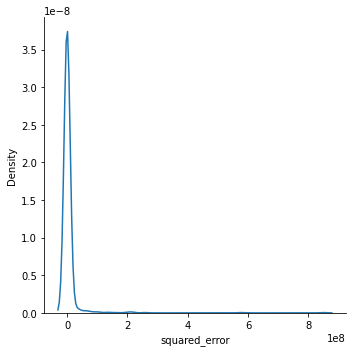

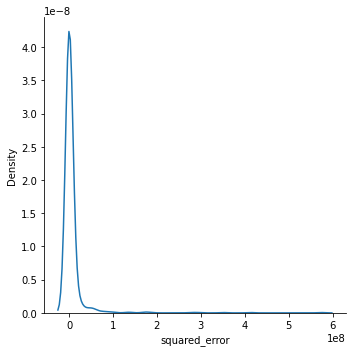

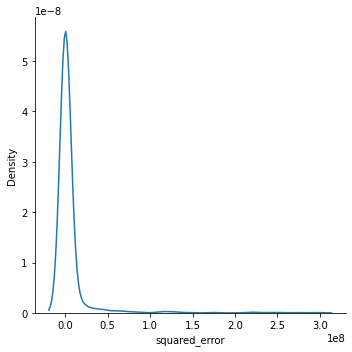

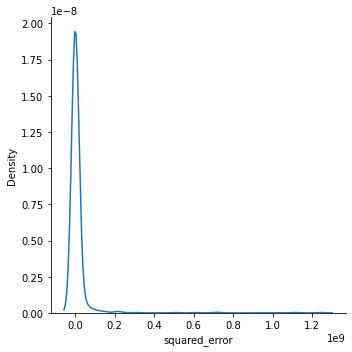

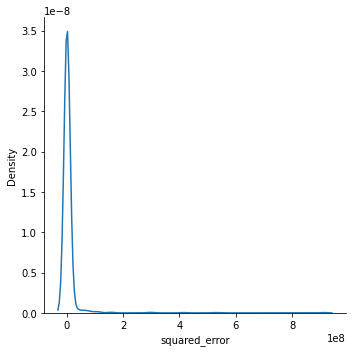

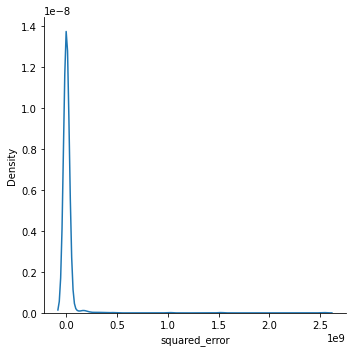

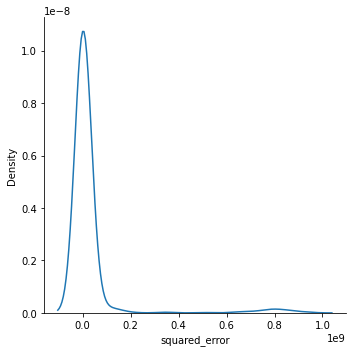

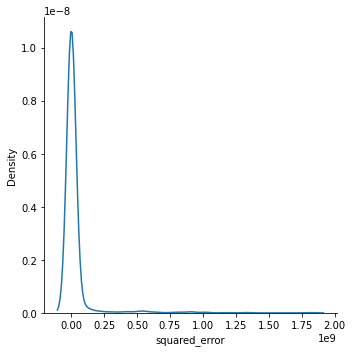

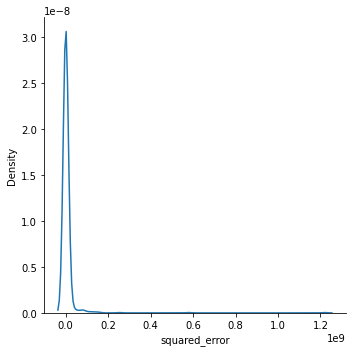

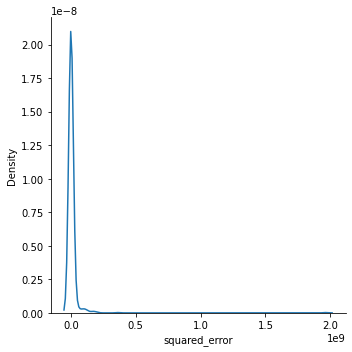

In [108]:
# fig = make_subplots(rows=10, cols=1)
for idx, city in enumerate(CITIES):

    resid = cities_dictionary.get(city)[2]
    sns.displot(resid["squared_error"], kind="kde")

# fig.show()

## Isolation Forest Modelling Phase

In [157]:
CITIES

['balikpapan',
 'bandung',
 'batam',
 'jakarta',
 'makassar',
 'medan',
 'palembang',
 'pekanbaru',
 'surabaya',
 'yogyakarta']

In [169]:
cities_dictionary.keys()

dict_keys(['balikpapan', 'bandung', 'batam', 'jakarta', 'makassar', 'medan', 'palembang', 'pekanbaru', 'surabaya', 'yogyakarta'])

In [243]:
from sklearn.ensemble import IsolationForest

# Loop over city :
fitted_iso_forest = {}
for idx, city in enumerate(list(cities_dictionary.keys())):
    # instanciate isolation forest model
    resid = cities_dictionary.get(city)[2].dropna()
    iso_forest = IsolationForest(random_state=67)
    array_outlier = iso_forest.fit_predict(resid["squared_error"].values.reshape(-1, 1))
    resid["outlier"] = array_outlier
    cities_dictionary[city].append(resid)
    fitted_iso_forest[city] = [iso_forest, resid]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [248]:
cities_dictionary

{'balikpapan': [<prophet.forecaster.Prophet at 0x7fd00609a210>,
               ds       trend   yhat_lower   yhat_upper  trend_lower  \
  0    2018-01-01  -24.988416 -2709.893515  3137.592930   -24.988416   
  1    2018-01-02  -24.873405 -2718.327602  3140.971784   -24.873405   
  2    2018-01-03  -24.758395 -2554.181325  3098.859308   -24.758395   
  3    2018-01-04  -24.643384 -2867.069902  2927.249029   -24.643384   
  4    2018-01-05  -24.528373 -2977.933264  2805.570225   -24.528373   
  ...         ...         ...          ...          ...          ...   
  1778 2022-11-14  230.065195 -2662.987597  3088.537441   230.065195   
  1779 2022-11-15  230.236169 -2490.479401  3225.936252   230.236169   
  1780 2022-11-16  230.407142 -2274.636567  3247.497245   230.407142   
  1781 2022-11-17  230.578116 -2529.963370  3067.162764   230.578116   
  1782 2022-11-18  230.749089 -2756.101137  2951.646274   230.749089   
  
        trend_upper  additive_terms  additive_terms_lower  additive_t

In [249]:
fitted_iso_forest

{'balikpapan': [IsolationForest(random_state=67),
               ds   ytrue     residual  squared_error  outlier
  3    2018-01-04     0.0   -22.771243   5.185295e+02        1
  4    2018-01-05     0.0    31.791471   1.010698e+03        1
  8    2018-01-09     0.0   252.664778   6.383949e+04        1
  9    2018-01-10  4000.0  4079.482757   1.664218e+07       -1
  10   2018-01-11     0.0   338.695314   1.147145e+05        1
  ...         ...     ...          ...            ...      ...
  1775 2022-11-11     0.0  -256.811386   6.595209e+04        1
  1779 2022-11-15     0.0  -288.768694   8.338736e+04        1
  1780 2022-11-16 -5050.0 -5551.713373   3.082152e+07       -1
  1781 2022-11-17     0.0  -272.129294   7.405435e+04        1
  1782 2022-11-18     0.0  -268.861541   7.228653e+04        1
  
  [910 rows x 5 columns]],
 'bandung': [IsolationForest(random_state=67),
               ds   ytrue     residual  squared_error  outlier
  3    2018-01-04     0.0   -53.666434   2.880086e+03 

In [250]:
def pipe_concat(data, city):
    print(data["outlier"])
    data = data.copy()
    data["outlier"] = data["outlier"].map({1: "inlier", -1: "outlier"})
    print(data["outlier"])
    data = data.rename(
        columns={
            "squared_error": f"squared_error_{city}",
            "ytrue": f"ytrue_{city}",
            "outlier": f"outlier_{city}",
            "residual": f"residual_{city}",
        }
    )
    print(data)
    return data

In [251]:
from IPython.display import display

container = []
for idx, city in enumerate(list(cities_dictionary.keys())):
    print(f"{city}")
    resid = fitted_iso_forest.get(city)[1].pipe(pipe_concat, city)
    print(resid)
    container.append(resid)

balikpapan
3       1
4       1
8       1
9      -1
10      1
       ..
1775    1
1779    1
1780   -1
1781    1
1782    1
Name: outlier, Length: 910, dtype: int64
3        inlier
4        inlier
8        inlier
9       outlier
10       inlier
         ...   
1775     inlier
1779     inlier
1780    outlier
1781     inlier
1782     inlier
Name: outlier, Length: 910, dtype: object
             ds  ytrue_balikpapan  residual_balikpapan  \
3    2018-01-04               0.0           -22.771243   
4    2018-01-05               0.0            31.791471   
8    2018-01-09               0.0           252.664778   
9    2018-01-10            4000.0          4079.482757   
10   2018-01-11               0.0           338.695314   
...         ...               ...                  ...   
1775 2022-11-11               0.0          -256.811386   
1779 2022-11-15               0.0          -288.768694   
1780 2022-11-16           -5050.0         -5551.713373   
1781 2022-11-17               0.0       

In [252]:
container

[             ds  ytrue_balikpapan  residual_balikpapan  \
 3    2018-01-04               0.0           -22.771243   
 4    2018-01-05               0.0            31.791471   
 8    2018-01-09               0.0           252.664778   
 9    2018-01-10            4000.0          4079.482757   
 10   2018-01-11               0.0           338.695314   
 ...         ...               ...                  ...   
 1775 2022-11-11               0.0          -256.811386   
 1779 2022-11-15               0.0          -288.768694   
 1780 2022-11-16           -5050.0         -5551.713373   
 1781 2022-11-17               0.0          -272.129294   
 1782 2022-11-18               0.0          -268.861541   
 
       squared_error_balikpapan outlier_balikpapan  
 3                 5.185295e+02             inlier  
 4                 1.010698e+03             inlier  
 8                 6.383949e+04             inlier  
 9                 1.664218e+07            outlier  
 10                1.1471

## Sanity Check

In [178]:
iso_forest_balikpapan = IsolationForest(random_state=67)
combined_outlier["outlier_balikpapan"] = iso_forest_balikpapan.fit_predict(
    combined_outlier["squared_error_balikpapan"].values.reshape(-1, 1)
)

In [180]:
combined_outlier["outlier_balikpapan"] = combined_outlier["outlier_balikpapan"].map(
    {1: "inlier", -1: "outlier"}
)

In [182]:
fitted_iso_forest["balikpapan"][0] = iso_forest_balikpapan

In [185]:
filter_balikpapan = combined_outlier["outlier_balikpapan"] == "outlier"
combined_outlier.loc[
    filter_balikpapan, ["ytrue_balikpapan", "squared_error_balikpapan", "ds"]
]

,ytrue_balikpapan,squared_error_balikpapan,ds
9,4000.0,16642179.56776,2018-01-10
16,-16250.0,257798799.234949,2018-01-17
30,2350.0,4787624.708346,2018-01-31
37,-1800.0,3766907.373405,2018-02-07
51,1300.0,2380081.485701,2018-02-21
...,...,...,...
1682,5300.0,24760165.844513,2022-08-10
1710,-10000.0,103322912.727766,2022-09-07
1717,6500.0,37544196.733285,2022-09-14
1752,-9250.0,79838513.914791,2022-10-19


In [195]:
combined_outlier["outlier_balikpapan"].value_counts()

inlier     839
outlier     71
Name: outlier_balikpapan, dtype: int64

In [199]:
filter_balikpapan_outlier = combined_outlier["outlier_balikpapan"] == "outlier"

In [200]:
combined_outlier.loc[
    filter_balikpapan_outlier, ["ytrue_balikpapan", "squared_error_balikpapan", "ds"]
]

,ytrue_balikpapan,squared_error_balikpapan,ds
9,4000.0,16642179.56776,2018-01-10
16,-16250.0,257798799.234949,2018-01-17
30,2350.0,4787624.708346,2018-01-31
37,-1800.0,3766907.373405,2018-02-07
51,1300.0,2380081.485701,2018-02-21
...,...,...,...
1682,5300.0,24760165.844513,2022-08-10
1710,-10000.0,103322912.727766,2022-09-07
1717,6500.0,37544196.733285,2022-09-14
1752,-9250.0,79838513.914791,2022-10-19


In [208]:
range_squared = combined_outlier.loc[
    filter_balikpapan_outlier, ["ytrue_balikpapan", "squared_error_balikpapan", "ds"]
]["ytrue_balikpapan"]

In [210]:
range_squared_inlier = combined_outlier.loc[
    filter_balikpapan_inl, ["ytrue_balikpapan", "squared_error_balikpapan", "ds"]
]["ytrue_balikpapan"]

In [209]:
px.histogram(range_squared)

In [211]:
combined_outlier.loc[
    filter_balikpapan_inl, ["ytrue_balikpapan", "squared_error_balikpapan", "ds"]
]["ytrue_balikpapan"]

In [ ]:
range_squared_inlier

In [237]:
combined_outlier = pd.concat(container, axis=1)
combined_outlier = combined_outlier.T.drop_duplicates().T

In [238]:
combined_outlier.isnull().sum()

ds                          0
ytrue_balikpapan            0
residual_balikpapan         0
squared_error_balikpapan    0
outlier                     0
ytrue_bandung               0
residual_bandung            0
squared_error_bandung       0
outlier                     0
ytrue_batam                 0
residual_batam              0
squared_error_batam         0
outlier                     0
ytrue_jakarta               0
residual_jakarta            0
squared_error_jakarta       0
outlier                     0
ytrue_makassar              0
residual_makassar           0
squared_error_makassar      0
outlier                     0
ytrue_medan                 0
residual_medan              0
squared_error_medan         0
outlier                     0
ytrue_palembang             0
residual_palembang          0
squared_error_palembang     0
outlier                     0
ytrue_pekanbaru             0
residual_pekanbaru          0
squared_error_pekanbaru     0
outlier                     0
ytrue_sura

## 

In [239]:
combined_outlier

,ds,ytrue_balikpapan,residual_balikpapan,squared_error_balikpapan,outlier,ytrue_bandung,residual_bandung,squared_error_bandung,outlier,ytrue_batam,...,squared_error_pekanbaru,outlier,ytrue_surabaya,residual_surabaya,squared_error_surabaya,outlier,ytrue_yogyakarta,residual_yogyakarta,squared_error_yogyakarta,outlier
3,2018-01-04,0.0,-22.771243,518.529525,inlier,0.0,-53.666434,2880.086086,inlier,0.0,...,155911.534267,inlier,0.0,-1164.79727,1356752.68088,inlier,0.0,-109.653549,12023.900712,inlier
4,2018-01-05,0.0,31.791471,1010.697619,inlier,0.0,36.012464,1296.897553,inlier,0.0,...,1557242.546005,inlier,0.0,-1082.232072,1171226.258635,inlier,0.0,-10.248727,105.036397,inlier
8,2018-01-09,0.0,252.664778,63839.489999,inlier,0.0,-156.646789,24538.216488,inlier,0.0,...,2037872.396939,inlier,0.0,-871.677319,759821.348963,inlier,0.0,-157.125211,24688.331822,inlier
9,2018-01-10,4000.0,4079.482757,16642179.56776,outlier,-1900.0,-2045.10183,4182441.494989,outlier,600.0,...,892136.68581,inlier,10200.0,9251.812892,85596041.782324,outlier,0.0,-149.136906,22241.81665,inlier
10,2018-01-11,0.0,338.695314,114714.515625,inlier,0.0,-76.488623,5850.509429,inlier,0.0,...,184954.012194,inlier,0.0,-659.777895,435306.871306,inlier,0.0,-41.0095,1681.779086,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2022-11-11,0.0,-256.811386,65952.088182,inlier,0.0,182.175206,33187.805624,inlier,0.0,...,124192.554947,inlier,0.0,-113.259299,12827.668737,inlier,0.0,-281.961298,79502.173651,inlier
1779,2022-11-15,0.0,-288.768694,83387.35845,inlier,0.0,128.973537,16634.173324,inlier,0.0,...,55915.684918,inlier,0.0,-180.954211,32744.42656,inlier,0.0,-190.140257,36153.317245,inlier
1780,2022-11-16,-5050.0,-5551.713373,30821521.37417,outlier,-7000.0,-6827.17393,46610303.866422,outlier,500.0,...,852764.435291,inlier,-4750.0,-5080.515643,25811639.201963,outlier,-14100.0,-14219.089536,202182507.243611,outlier
1781,2022-11-17,0.0,-272.129294,74054.352701,inlier,0.0,269.845439,72816.561196,inlier,0.0,...,1264824.715883,inlier,0.0,-112.588856,12676.250505,inlier,0.0,48.73994,2375.581711,inlier


In [223]:
combined_outlier.columns

Index(['ds', 'ytrue_balikpapan', 'residual_balikpapan',
       'squared_error_balikpapan', 'outlier_balikpapan', 'ytrue_bandung',
       'residual_bandung', 'squared_error_bandung', 'ytrue_batam',
       'residual_batam', 'squared_error_batam', 'ytrue_jakarta',
       'residual_jakarta', 'squared_error_jakarta', 'ytrue_makassar',
       'residual_makassar', 'squared_error_makassar', 'ytrue_medan',
       'residual_medan', 'squared_error_medan', 'ytrue_palembang',
       'residual_palembang', 'squared_error_palembang', 'ytrue_pekanbaru',
       'residual_pekanbaru', 'squared_error_pekanbaru', 'ytrue_surabaya',
       'residual_surabaya', 'squared_error_surabaya', 'ytrue_yogyakarta',
       'residual_yogyakarta', 'squared_error_yogyakarta'],
      dtype='object')

In [247]:
combined_outlier

,ds,ytrue_balikpapan,residual_balikpapan,squared_error_balikpapan,outlier,ytrue_bandung,residual_bandung,squared_error_bandung,outlier,ytrue_batam,...,squared_error_pekanbaru,outlier,ytrue_surabaya,residual_surabaya,squared_error_surabaya,outlier,ytrue_yogyakarta,residual_yogyakarta,squared_error_yogyakarta,outlier
3,2018-01-04,0.0,-22.771243,518.529525,inlier,0.0,-53.666434,2880.086086,inlier,0.0,...,155911.534267,inlier,0.0,-1164.79727,1356752.68088,inlier,0.0,-109.653549,12023.900712,inlier
4,2018-01-05,0.0,31.791471,1010.697619,inlier,0.0,36.012464,1296.897553,inlier,0.0,...,1557242.546005,inlier,0.0,-1082.232072,1171226.258635,inlier,0.0,-10.248727,105.036397,inlier
8,2018-01-09,0.0,252.664778,63839.489999,inlier,0.0,-156.646789,24538.216488,inlier,0.0,...,2037872.396939,inlier,0.0,-871.677319,759821.348963,inlier,0.0,-157.125211,24688.331822,inlier
9,2018-01-10,4000.0,4079.482757,16642179.56776,outlier,-1900.0,-2045.10183,4182441.494989,outlier,600.0,...,892136.68581,inlier,10200.0,9251.812892,85596041.782324,outlier,0.0,-149.136906,22241.81665,inlier
10,2018-01-11,0.0,338.695314,114714.515625,inlier,0.0,-76.488623,5850.509429,inlier,0.0,...,184954.012194,inlier,0.0,-659.777895,435306.871306,inlier,0.0,-41.0095,1681.779086,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2022-11-11,0.0,-256.811386,65952.088182,inlier,0.0,182.175206,33187.805624,inlier,0.0,...,124192.554947,inlier,0.0,-113.259299,12827.668737,inlier,0.0,-281.961298,79502.173651,inlier
1779,2022-11-15,0.0,-288.768694,83387.35845,inlier,0.0,128.973537,16634.173324,inlier,0.0,...,55915.684918,inlier,0.0,-180.954211,32744.42656,inlier,0.0,-190.140257,36153.317245,inlier
1780,2022-11-16,-5050.0,-5551.713373,30821521.37417,outlier,-7000.0,-6827.17393,46610303.866422,outlier,500.0,...,852764.435291,inlier,-4750.0,-5080.515643,25811639.201963,outlier,-14100.0,-14219.089536,202182507.243611,outlier
1781,2022-11-17,0.0,-272.129294,74054.352701,inlier,0.0,269.845439,72816.561196,inlier,0.0,...,1264824.715883,inlier,0.0,-112.588856,12676.250505,inlier,0.0,48.73994,2375.581711,inlier


## Outlier Annotation

In [255]:
combined_outliers = pd.concat(container)

In [256]:
combined_outliers

,ds,ytrue_balikpapan,residual_balikpapan,squared_error_balikpapan,outlier_balikpapan,ytrue_bandung,residual_bandung,squared_error_bandung,outlier_bandung,ytrue_batam,...,squared_error_pekanbaru,outlier_pekanbaru,ytrue_surabaya,residual_surabaya,squared_error_surabaya,outlier_surabaya,ytrue_yogyakarta,residual_yogyakarta,squared_error_yogyakarta,outlier_yogyakarta
3,2018-01-04,0.0,-22.771243,5.185295e+02,inlier,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,0.0,31.791471,1.010698e+03,inlier,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-09,0.0,252.664778,6.383949e+04,inlier,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-01-10,4000.0,4079.482757,1.664218e+07,outlier,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2018-01-11,0.0,338.695314,1.147145e+05,inlier,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,2022-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-281.961298,7.950217e+04,inlier
1779,2022-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-190.140257,3.615332e+04,inlier
1780,2022-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-14100.0,-14219.089536,2.021825e+08,outlier
1781,2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,48.739940,2.375582e+03,inlier


In [273]:
def generate_outlier_plot(city):
    figure_outlier = go.Figure()
    parsed_data = data_diffed[[city]].reset_index()
    trace1 = go.Scatter(
        y=parsed_data[f"{city}"], x=parsed_data.tanggal, mode="lines", name=f"{city}"
    )
    figure_outlier.add_trace(trace=trace1)
    # #get anotated result
    filter_date = combined_outliers[f"outlier_{city}"] == "outlier"
    list_date = combined_outliers.loc[filter_date, "ds"].to_list()
    parsed_outlier_filter = parsed_data["tanggal"].isin(list_date)
    parsed_data_outlier_df = parsed_data.loc[parsed_outlier_filter]
    trace2 = go.Scatter(
        y=parsed_data_outlier_df[f"{city}"],
        x=parsed_data_outlier_df.tanggal,
        mode="markers",
        name=f"{city}",
    )
    figure_outlier.add_trace(trace=trace2)
    figure_outlier.update_layout(
        width=2000,
        height=500,
        margin=dict(l=0, r=0, b=0, t=0),
        xaxis_rangeslider_visible=True,
    )
    figure_outlier.show()

In [277]:
generate_outlier_plot("medan")

In [275]:
generate_outlier_plot("bandung")

In [266]:
# figure_outlier = make_subplots(rows=10,cols=1)
# for idx,city in enumerate(CITIES) :
#   #get data diffed
#   parsed_data = data_diffed[[city]].reset_index()
#   print(parsed_data.columns)
#   trace1 = go.Scatter(y=parsed_data[f'{city}'], x=parsed_data.tanggal,
#                       mode='lines',
#                       name=f'{city}')
#   figure_outlier.add_trace(trace1,row=idx+1,col=1)
#   # #get anotated result
#   filter_date = combined_outliers[f'outlier_{city}']=='outlier'
#   list_date=combined_outliers.loc[filter_date,'ds'].to_list()
#   print(list_date)
#   parsed_outlier_filter = parsed_data['tanggal'].isin(list_date)
#   parsed_data_outlier_df = parsed_data.loc[parsed_outlier_filter]
#   trace2 = go.Scatter(y=parsed_data_outlier_df[f'{city}'], x=parsed_data_outlier_df.tanggal,
#                       mode='markers',
#                       name=f'{city}')
#   figure_outlier.add_trace(trace2,row=idx+1,col=1)

# figure_outlier.update_layout(width=2000,height=5000,margin=dict(l=0,r=0,b=0,t=0),xaxis_rangeslider_visible=True)
# figure_outlier.show()

#   #filter

Index(['tanggal', 'balikpapan'], dtype='object')
[Timestamp('2018-01-10 00:00:00'), Timestamp('2018-01-17 00:00:00'), Timestamp('2018-01-31 00:00:00'), Timestamp('2018-02-07 00:00:00'), Timestamp('2018-02-21 00:00:00'), Timestamp('2018-04-04 00:00:00'), Timestamp('2018-04-25 00:00:00'), Timestamp('2018-05-09 00:00:00'), Timestamp('2018-05-16 00:00:00'), Timestamp('2018-05-23 00:00:00'), Timestamp('2018-07-04 00:00:00'), Timestamp('2018-08-08 00:00:00'), Timestamp('2018-10-31 00:00:00'), Timestamp('2019-04-24 00:00:00'), Timestamp('2019-05-15 00:00:00'), Timestamp('2019-05-22 00:00:00'), Timestamp('2019-07-03 00:00:00'), Timestamp('2019-09-11 00:00:00'), Timestamp('2019-10-16 00:00:00'), Timestamp('2019-11-27 00:00:00'), Timestamp('2020-02-05 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-20 00:00:00'), Timestamp('2020-06-17 00:00:00'), Timestamp('2020-07-08 00:00:00'), Timestamp('2020-08-12 00:00:00'), Timestamp('2020-08-19 00:00:00')

In [254]:
combined_data

NameError: ignored